In [1]:
import sys
sys.path.append("..")

from predict import perform_inference
from rfw_loader import create_dataloaders
from train import train, save_model

import torch

In [2]:
EPOCHS = 5
LEARNING_RATE = 0.01

BATCH_SIZE = 32
DEVICE = 2

In [3]:
device = torch.device(f'cuda:{DEVICE}' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=2)

# Get Train and Validation Loss Curves

In [4]:
import torch
import torchvision.models as models
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F


class MultiHeadResNet(nn.Module):
    def __init__(self, output_dims):
        super(MultiHeadResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))
        self.heads = nn.ModuleDict()
        for head, num_classes in output_dims.items():
            self.heads[head] = nn.Linear(num_features, num_classes)

    def forward(self, x):
        features = self.resnet(x).squeeze()
        outputs = {}
        for head, head_module in self.heads.items():
            output_logits = head_module(features)
            outputs[head] = F.softmax(output_logits, dim=1)
        return outputs

In [5]:
lambda_value = 64
data_rate = 1
ROOT = '/media/global_data/fair_neural_compression_data/decoded_rfw'

compressed_image_path = f'{ROOT}/progressive_64x64/qres17m/q_{lambda_value}/{data_rate}'
RFW_LABELS_DIR = "/media/global_data/fair_neural_compression_data/datasets/RFW/clean_metadata/numerical_labels.csv"
train_loader, valid_loader, test_loader = create_dataloaders(
    compressed_image_path, 
    RFW_LABELS_DIR, 
    BATCH_SIZE, 
    RATIO
)

/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [32]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np

RACE_LABELS = ['Indian', 'Asian', 'African', 'Caucasian']

def train_numerical_rfw(
        model, 
        optimizer,
        num_epochs, 
        lr, 
        train_loader, 
        valid_loader,
        device,
        save_dir,
        model_name,
        patience=5  # Number of epochs to wait for improvement in validation loss before stopping
    ):
    criterion = nn.CrossEntropyLoss()
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer = optimizer(model.parameters(), lr=lr)
    
    train_losses = []
    valid_losses = []
    
    best_valid_loss = float('inf')
    no_improvement_count = 0
    
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs} - Training") as pbar:
            for inputs, targets, races in train_loader:
                inputs, targets = inputs.to(device).float(), targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = 0
                for i, head in enumerate(outputs):
                    loss += criterion(outputs[head], targets[:, i].to(torch.int64))
                loss.backward()
                optimizer.step()
                running_train_loss += loss.item() * inputs.size(0)
                pbar.update(1)
            avg_train_loss = running_train_loss / len(train_loader.dataset)
            pbar.set_postfix(train_loss=avg_train_loss)
        
        print(f'Epoch {epoch + 1} train loss : {avg_train_loss}')
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        running_valid_loss = 0.0
        with torch.no_grad():
            with tqdm(total=len(valid_loader), desc=f"Epoch {epoch+1}/{num_epochs} - Validation") as pbar:
                for inputs, targets, races in valid_loader:
                    inputs, targets = inputs.to(device).float(), targets.to(device)
                    outputs = model(inputs)
                    loss = 0
                    for i, head in enumerate(outputs):
                        loss += criterion(outputs[head], targets[:, i].to(torch.int64))
                    running_valid_loss += loss.item() * inputs.size(0)
                    pbar.update(1)
                avg_valid_loss = running_valid_loss / len(valid_loader.dataset)  # Compute average validation loss
                pbar.set_postfix(valid_loss=avg_valid_loss)
        print(f'Epoch {epoch + 1} valid loss : {avg_valid_loss}')
        valid_losses.append(avg_valid_loss)
        
        # Check for early stopping
        if avg_valid_loss < best_valid_loss:
            print(f'Found better model. Best loss: {avg_valid_loss}')
            best_valid_loss = avg_valid_loss
            no_improvement_count = 0
            print(f'Saving best model to {save_dir}/best_{model_name}.pth')
            torch.save(model, f'{save_dir}/best_{model_name}.pth')
        else:
            no_improvement_count += 1
            if no_improvement_count >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break
    
    return model, train_losses, valid_losses

/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warn

Epoch 1 train loss : 5.927084055813876


Epoch 1/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.77it/s, valid_loss=5.9]


Epoch 1 valid loss : 5.8985828216626635
Found better model. Best loss: 5.8985828216626635
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=1.pth


Epoch 2/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.60it/s, train_loss=5.87]


Epoch 2 train loss : 5.87376628269654


Epoch 2/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.55it/s, valid_loss=5.87]


Epoch 2 valid loss : 5.866966776847057
Found better model. Best loss: 5.866966776847057
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=1.pth


Epoch 3/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.72it/s, train_loss=5.86]


Epoch 3 train loss : 5.8557755362641934


Epoch 3/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.60it/s, valid_loss=5.86]


Epoch 3 valid loss : 5.861350239957422
Found better model. Best loss: 5.861350239957422
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=1.pth


Epoch 4/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.68it/s, train_loss=5.84]


Epoch 4 train loss : 5.840639745689197


Epoch 4/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.79it/s, valid_loss=5.87]


Epoch 4 valid loss : 5.86610848765482


Epoch 5/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.69it/s, train_loss=5.83]


Epoch 5 train loss : 5.825651395096096


Epoch 5/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.18it/s, valid_loss=5.89]


Epoch 5 valid loss : 5.885446853775478


Epoch 6/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.66it/s, train_loss=5.81]


Epoch 6 train loss : 5.809890267549016


Epoch 6/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.35it/s, valid_loss=5.88]


Epoch 6 valid loss : 5.8784007182205045


Epoch 7/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.74it/s, train_loss=5.8]


Epoch 7 train loss : 5.796017559689265


Epoch 7/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.77it/s, valid_loss=5.9]


Epoch 7 valid loss : 5.896049908945036


Epoch 8/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.60it/s, train_loss=5.77]


Epoch 8 train loss : 5.774116365935747


Epoch 8/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.59it/s, valid_loss=5.89]


Epoch 8 valid loss : 5.886470186712315


Epoch 9/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.69it/s, train_loss=5.76]


Epoch 9 train loss : 5.757756513573571


Epoch 9/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.80it/s, valid_loss=5.89]


Epoch 9 valid loss : 5.894015090646777


Epoch 10/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.58it/s, train_loss=5.73]


Epoch 10 train loss : 5.73146674708853


Epoch 10/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.88it/s, valid_loss=5.9]


Epoch 10 valid loss : 5.899817288792832


Epoch 11/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.60it/s, train_loss=5.71]


Epoch 11 train loss : 5.710991618132008


Epoch 11/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.66it/s, valid_loss=5.93]


Epoch 11 valid loss : 5.928119324753191


Epoch 12/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.61it/s, train_loss=5.69]


Epoch 12 train loss : 5.688646287942248


Epoch 12/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.87it/s, valid_loss=5.91]


Epoch 12 valid loss : 5.914584663227027


Epoch 13/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.60it/s, train_loss=5.66]


Epoch 13 train loss : 5.659780986672081


Epoch 13/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.55it/s, valid_loss=5.96]


Epoch 13 valid loss : 5.955711544098241
Early stopping at epoch 13


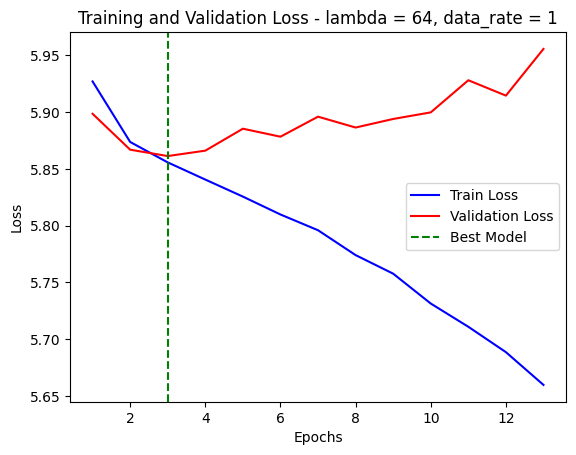

/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warn

Epoch 1 train loss : 5.934665858695247


Epoch 1/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.20it/s, valid_loss=5.86]


Epoch 1 valid loss : 5.8582653886597456
Found better model. Best loss: 5.8582653886597456
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=3.pth


Epoch 2/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.81it/s, train_loss=5.84]


Epoch 2 train loss : 5.844063412596265


Epoch 2/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.06it/s, valid_loss=5.86]


Epoch 2 valid loss : 5.855551755363729
Found better model. Best loss: 5.855551755363729
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=3.pth


Epoch 3/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.80it/s, train_loss=5.82]


Epoch 3 train loss : 5.818498712373793


Epoch 3/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.47it/s, valid_loss=5.84]


Epoch 3 valid loss : 5.838055118867044
Found better model. Best loss: 5.838055118867044
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=3.pth


Epoch 4/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.73it/s, train_loss=5.8]


Epoch 4 train loss : 5.799914986792666


Epoch 4/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.64it/s, valid_loss=5.84]


Epoch 4 valid loss : 5.841610552152572


Epoch 5/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.35it/s, train_loss=5.78]


Epoch 5 train loss : 5.777077435306385


Epoch 5/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.87it/s, valid_loss=5.83]


Epoch 5 valid loss : 5.830572063397195
Found better model. Best loss: 5.830572063397195
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=3.pth


Epoch 6/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.59it/s, train_loss=5.76]


Epoch 6 train loss : 5.757943010987814


Epoch 6/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.51it/s, valid_loss=5.84]


Epoch 6 valid loss : 5.836619465050879


Epoch 7/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.71it/s, train_loss=5.73]


Epoch 7 train loss : 5.732231395398265


Epoch 7/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.77it/s, valid_loss=5.84]


Epoch 7 valid loss : 5.838949367734251


Epoch 8/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.78it/s, train_loss=5.71]


Epoch 8 train loss : 5.710168903993949


Epoch 8/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.76it/s, valid_loss=5.86]


Epoch 8 valid loss : 5.8599012535676405


Epoch 9/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.65it/s, train_loss=5.69]


Epoch 9 train loss : 5.688931282224905


Epoch 9/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.62it/s, valid_loss=5.9]


Epoch 9 valid loss : 5.903827368968462


Epoch 10/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.53it/s, train_loss=5.66]


Epoch 10 train loss : 5.6591654426441576


Epoch 10/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.39it/s, valid_loss=5.86]


Epoch 10 valid loss : 5.857306667275273


Epoch 11/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.64it/s, train_loss=5.63]


Epoch 11 train loss : 5.632588428945029


Epoch 11/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.39it/s, valid_loss=5.9]


Epoch 11 valid loss : 5.8990733820392744


Epoch 12/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.80it/s, train_loss=5.6]


Epoch 12 train loss : 5.59949739919459


Epoch 12/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.75it/s, valid_loss=5.89]


Epoch 12 valid loss : 5.886407269180515


Epoch 13/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.91it/s, train_loss=5.57]


Epoch 13 train loss : 5.574659955491491


Epoch 13/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.73it/s, valid_loss=5.91]


Epoch 13 valid loss : 5.908622901245127


Epoch 14/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.81it/s, train_loss=5.54]


Epoch 14 train loss : 5.538342542457742


Epoch 14/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.50it/s, valid_loss=5.89]


Epoch 14 valid loss : 5.894236594384732


Epoch 15/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.70it/s, train_loss=5.51]


Epoch 15 train loss : 5.5076397782542355


Epoch 15/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.45it/s, valid_loss=5.91]


Epoch 15 valid loss : 5.905382528228334
Early stopping at epoch 15


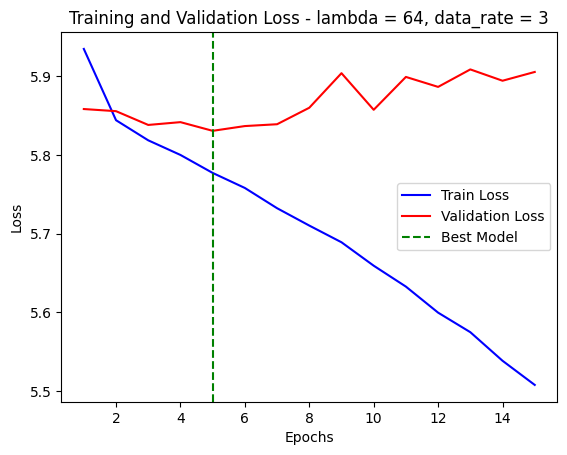

/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warn

Epoch 1 train loss : 5.68846364830569


Epoch 1/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.19it/s, valid_loss=5.57]


Epoch 1 valid loss : 5.565647177225732
Found better model. Best loss: 5.565647177225732
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=6.pth


Epoch 2/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.76it/s, train_loss=5.51]


Epoch 2 train loss : 5.5120358828118645


Epoch 2/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.60it/s, valid_loss=5.5]


Epoch 2 valid loss : 5.502175862987608
Found better model. Best loss: 5.502175862987608
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=6.pth


Epoch 3/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.65it/s, train_loss=5.45]


Epoch 3 train loss : 5.452597278022712


Epoch 3/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 41.93it/s, valid_loss=5.51]


Epoch 3 valid loss : 5.509554103058442


Epoch 4/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.49it/s, train_loss=5.4]


Epoch 4 train loss : 5.4015445738754035


Epoch 4/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.08it/s, valid_loss=5.47]


Epoch 4 valid loss : 5.468939522533576
Found better model. Best loss: 5.468939522533576
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=6.pth


Epoch 5/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.67it/s, train_loss=5.35]


Epoch 5 train loss : 5.352788121674116


Epoch 5/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.10it/s, valid_loss=5.5]


Epoch 5 valid loss : 5.504497090694921


Epoch 6/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.81it/s, train_loss=5.3]


Epoch 6 train loss : 5.300589018998064


Epoch 6/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.37it/s, valid_loss=5.47]


Epoch 6 valid loss : 5.474145501299144


Epoch 7/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.85it/s, train_loss=5.24]


Epoch 7 train loss : 5.2443432897841


Epoch 7/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.21it/s, valid_loss=5.49]


Epoch 7 valid loss : 5.494918791693119


Epoch 8/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.87it/s, train_loss=5.16]


Epoch 8 train loss : 5.161287004431637


Epoch 8/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.59it/s, valid_loss=5.48]


Epoch 8 valid loss : 5.476741449603148


Epoch 9/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.80it/s, train_loss=5.09]


Epoch 9 train loss : 5.092202702744256


Epoch 9/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.04it/s, valid_loss=5.5]


Epoch 9 valid loss : 5.496113721499634


Epoch 10/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.82it/s, train_loss=5.03]


Epoch 10 train loss : 5.026189734155348


Epoch 10/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.61it/s, valid_loss=5.46]


Epoch 10 valid loss : 5.458575585032895
Found better model. Best loss: 5.458575585032895
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=6.pth


Epoch 11/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.60it/s, train_loss=4.97]


Epoch 11 train loss : 4.966530477232307


Epoch 11/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 41.71it/s, valid_loss=5.49]


Epoch 11 valid loss : 5.490492347425437


Epoch 12/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 29.99it/s, train_loss=4.92]


Epoch 12 train loss : 4.917774929182985


Epoch 12/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.30it/s, valid_loss=5.55]


Epoch 12 valid loss : 5.547237904626461


Epoch 13/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.56it/s, train_loss=4.86]


Epoch 13 train loss : 4.864785489383765


Epoch 13/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.46it/s, valid_loss=5.51]


Epoch 13 valid loss : 5.510212410457262


Epoch 14/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.52it/s, train_loss=4.82]


Epoch 14 train loss : 4.824958768791459


Epoch 14/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 41.82it/s, valid_loss=5.54]


Epoch 14 valid loss : 5.541075312862293


Epoch 15/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 29.92it/s, train_loss=4.79]


Epoch 15 train loss : 4.785217400842608


Epoch 15/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.09it/s, valid_loss=5.68]


Epoch 15 valid loss : 5.678691208920363


Epoch 16/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 29.91it/s, train_loss=4.75]


Epoch 16 train loss : 4.747684917884782


Epoch 16/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 41.24it/s, valid_loss=5.58]


Epoch 16 valid loss : 5.577101228664199


Epoch 17/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 29.81it/s, train_loss=4.72]


Epoch 17 train loss : 4.715865599951408


Epoch 17/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 41.23it/s, valid_loss=5.59]


Epoch 17 valid loss : 5.593908842904406


Epoch 18/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 29.98it/s, train_loss=4.68]


Epoch 18 train loss : 4.683610552973792


Epoch 18/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 41.75it/s, valid_loss=5.51]


Epoch 18 valid loss : 5.511051914410489


Epoch 19/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.09it/s, train_loss=4.67]


Epoch 19 train loss : 4.665259033802225


Epoch 19/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 41.55it/s, valid_loss=5.53]


Epoch 19 valid loss : 5.525061146572215


Epoch 20/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 29.94it/s, train_loss=4.64]


Epoch 20 train loss : 4.637888297476367


Epoch 20/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 41.94it/s, valid_loss=5.51]


Epoch 20 valid loss : 5.510574101188308
Early stopping at epoch 20


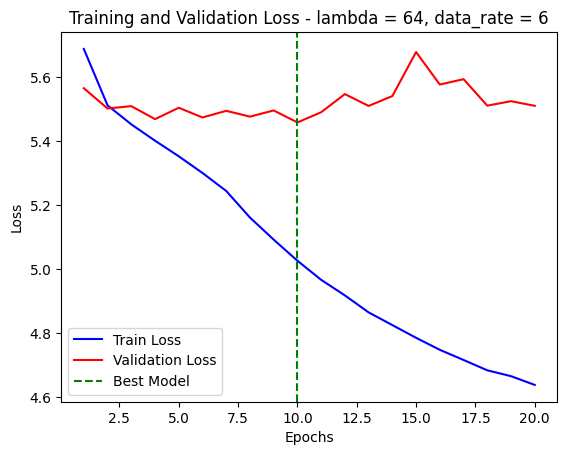

/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warn

Epoch 1 train loss : 5.64953754225349


Epoch 1/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.46it/s, valid_loss=5.48]


Epoch 1 valid loss : 5.476113507282243
Found better model. Best loss: 5.476113507282243
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=9.pth


Epoch 2/30 - Training: 100%|██████████| 889/889 [00:30<00:00, 29.49it/s, train_loss=5.44]


Epoch 2 train loss : 5.4351686032899424


Epoch 2/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.29it/s, valid_loss=5.43]


Epoch 2 valid loss : 5.42676739817162
Found better model. Best loss: 5.42676739817162
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=9.pth


Epoch 3/30 - Training: 100%|██████████| 889/889 [00:30<00:00, 29.43it/s, train_loss=5.37]


Epoch 3 train loss : 5.37435313181041


Epoch 3/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.35it/s, valid_loss=5.39]


Epoch 3 valid loss : 5.390191830979684
Found better model. Best loss: 5.390191830979684
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=9.pth


Epoch 4/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 29.78it/s, train_loss=5.32]


Epoch 4 train loss : 5.315769293527686


Epoch 4/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.28it/s, valid_loss=5.4]


Epoch 4 valid loss : 5.404706752431391


Epoch 5/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 29.70it/s, train_loss=5.27]


Epoch 5 train loss : 5.267327559621711


Epoch 5/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.22it/s, valid_loss=5.43]


Epoch 5 valid loss : 5.425103412553646


Epoch 6/30 - Training: 100%|██████████| 889/889 [00:30<00:00, 29.49it/s, train_loss=5.21]


Epoch 6 train loss : 5.208420188602111


Epoch 6/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.52it/s, valid_loss=5.44]


Epoch 6 valid loss : 5.44128923106127


Epoch 7/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 29.93it/s, train_loss=5.16]


Epoch 7 train loss : 5.156248053060328


Epoch 7/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.50it/s, valid_loss=5.41]


Epoch 7 valid loss : 5.411027140187583


Epoch 8/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 29.80it/s, train_loss=5.1]


Epoch 8 train loss : 5.095105092289949


Epoch 8/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.81it/s, valid_loss=5.4]


Epoch 8 valid loss : 5.397917598911624


Epoch 9/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.86it/s, train_loss=5.04]


Epoch 9 train loss : 5.04393336915849


Epoch 9/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.96it/s, valid_loss=5.46]


Epoch 9 valid loss : 5.464360901061155


Epoch 10/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.83it/s, train_loss=4.99]


Epoch 10 train loss : 4.992757216393696


Epoch 10/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.03it/s, valid_loss=5.43]


Epoch 10 valid loss : 5.428515822169934


Epoch 11/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.64it/s, train_loss=4.95]


Epoch 11 train loss : 4.953422850231167


Epoch 11/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.22it/s, valid_loss=5.44]


Epoch 11 valid loss : 5.435673942982397


Epoch 12/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.62it/s, train_loss=4.91]


Epoch 12 train loss : 4.913676110516459


Epoch 12/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.41it/s, valid_loss=5.45]


Epoch 12 valid loss : 5.453629037073887


Epoch 13/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.90it/s, train_loss=4.88]


Epoch 13 train loss : 4.875820986224066


Epoch 13/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.39it/s, valid_loss=5.44]


Epoch 13 valid loss : 5.437327361697928
Early stopping at epoch 13


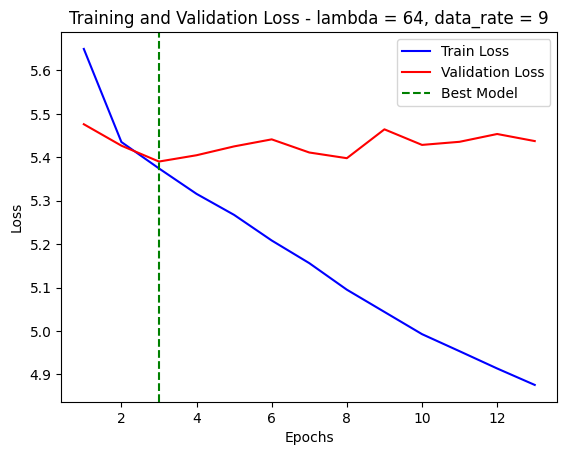

/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warn

Epoch 1 train loss : 5.618385382044862


Epoch 1/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.55it/s, valid_loss=5.43]


Epoch 1 valid loss : 5.42986588187649
Found better model. Best loss: 5.42986588187649
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=12.pth


Epoch 2/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.85it/s, train_loss=5.39]


Epoch 2 train loss : 5.393886718889576


Epoch 2/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.86it/s, valid_loss=5.38]


Epoch 2 valid loss : 5.3767940502138565
Found better model. Best loss: 5.3767940502138565
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=12.pth


Epoch 3/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.91it/s, train_loss=5.33]


Epoch 3 train loss : 5.331347732586892


Epoch 3/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.31it/s, valid_loss=5.4]


Epoch 3 valid loss : 5.403704891492925


Epoch 4/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.79it/s, train_loss=5.28]


Epoch 4 train loss : 5.275429782684911


Epoch 4/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.09it/s, valid_loss=5.37]


Epoch 4 valid loss : 5.368875906475658
Found better model. Best loss: 5.368875906475658
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=12.pth


Epoch 5/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.73it/s, train_loss=5.22]


Epoch 5 train loss : 5.2200707162631055


Epoch 5/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.70it/s, valid_loss=5.37]


Epoch 5 valid loss : 5.367915376773747
Found better model. Best loss: 5.367915376773747
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=12.pth


Epoch 6/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.76it/s, train_loss=5.17]


Epoch 6 train loss : 5.16781722408867


Epoch 6/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 43.13it/s, valid_loss=5.37]


Epoch 6 valid loss : 5.370277144798914


Epoch 7/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.63it/s, train_loss=5.11]


Epoch 7 train loss : 5.107451862192409


Epoch 7/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.80it/s, valid_loss=5.37]


Epoch 7 valid loss : 5.372214946737432


Epoch 8/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.64it/s, train_loss=5.05]


Epoch 8 train loss : 5.051956657621178


Epoch 8/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.71it/s, valid_loss=5.38]


Epoch 8 valid loss : 5.379398293809103


Epoch 9/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.51it/s, train_loss=5]


Epoch 9 train loss : 5.0013487859071555


Epoch 9/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.48it/s, valid_loss=5.42]


Epoch 9 valid loss : 5.418747139885163


Epoch 10/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.54it/s, train_loss=4.96]


Epoch 10 train loss : 4.955295661252014


Epoch 10/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.48it/s, valid_loss=5.39]


Epoch 10 valid loss : 5.389217653370045


Epoch 11/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.57it/s, train_loss=4.91]


Epoch 11 train loss : 4.9142593976446785


Epoch 11/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.38it/s, valid_loss=5.38]


Epoch 11 valid loss : 5.38478197524591


Epoch 12/30 - Training: 100%|██████████| 889/889 [00:29<00:00, 30.50it/s, train_loss=4.88]


Epoch 12 train loss : 4.881612198070308


Epoch 12/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.55it/s, valid_loss=5.46]


Epoch 12 valid loss : 5.460004654331486


Epoch 13/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.66it/s, train_loss=4.85]


Epoch 13 train loss : 4.85179232437108


Epoch 13/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.70it/s, valid_loss=5.39]


Epoch 13 valid loss : 5.394457349556457


Epoch 14/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.71it/s, train_loss=4.82]


Epoch 14 train loss : 4.822496634149699


Epoch 14/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.85it/s, valid_loss=5.42]


Epoch 14 valid loss : 5.4219552383617


Epoch 15/30 - Training: 100%|██████████| 889/889 [00:28<00:00, 30.66it/s, train_loss=4.8]


Epoch 15 train loss : 4.797129998635213


Epoch 15/30 - Validation: 100%|██████████| 191/191 [00:04<00:00, 42.74it/s, valid_loss=5.42]


Epoch 15 valid loss : 5.422297789220289
Early stopping at epoch 15


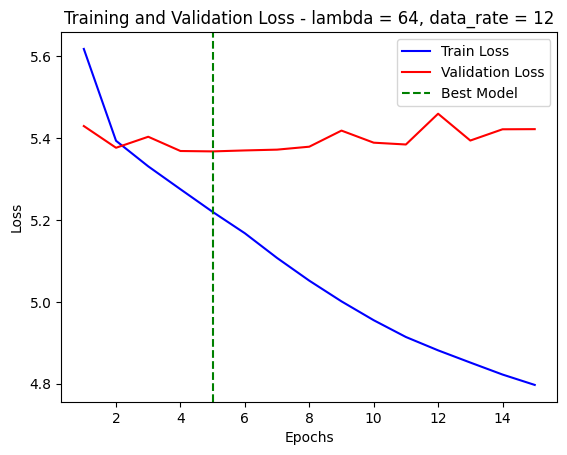

<Figure size 640x480 with 0 Axes>

In [33]:
import matplotlib.pyplot as plt

lambda_value = 64
data_rates = [1, 3, 6, 9, 12]
ROOT = '/media/global_data/fair_neural_compression_data/decoded_rfw'
RATIO = 0.7
num_epochs = 30
patience = 10
lr = 0.01

for data_rate in data_rates:
    compressed_image_path = f'{ROOT}/progressive_64x64/qres17m/q_{lambda_value}/{data_rate}'
    RFW_LABELS_DIR = "/media/global_data/fair_neural_compression_data/datasets/RFW/clean_metadata/numerical_labels.csv"
    train_loader, valid_loader, test_loader = create_dataloaders(
        compressed_image_path, 
        RFW_LABELS_DIR, 
        BATCH_SIZE, 
        RATIO
    )
    
    output_dims = {
        'skin_type': 6,
        'eye_type': 2,
        'nose_type': 2,
        'lip_type': 2,
        'hair_type': 4,
        'hair_color': 5
    }
    model = MultiHeadResNet(output_dims).to(device)
    
    trained_model, train_losses, valid_losses = train_numerical_rfw(
        model, 
        torch.optim.SGD,
        num_epochs, 
        lr, 
        train_loader, 
        valid_loader,
        device,
        '../../models/converged_models',
        f'RFW_resnet18_lambda={lambda_value}_data_rate={data_rate}',
        patience=patience
    )
    
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'b', label='Train Loss')
    plt.plot(epochs, valid_losses, 'r', label='Validation Loss')
    plt.title(f'Training and Validation Loss - lambda = {lambda_value}, data_rate = {data_rate}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    best_epoch = valid_losses.index(min(valid_losses)) + 1

    # Add a vertical line at the epoch with the lowest validation loss
    plt.axvline(x=best_epoch, color='g', linestyle='--', label='Best Model')

    plt.legend()
    plt.show()
    plt.savefig(f'/home/rasta/fair-neural-compression-eval/models/converged_models/plots/RFW_resnet18_lambda={lambda_value}_data_rate={data_rate}.png')

In [28]:
output_dims = {
    'skin_type': 6,
    'eye_type': 2,
    'nose_type': 2,
    'lip_type': 2,
    'hair_type': 4,
    'hair_color': 5
}
model = MultiHeadResNet(output_dims).to(device)
num_epochs = 30
patience = 10
lr = 0.01

trained_model, train_losses, valid_losses = train_numerical_rfw(
    model, 
    torch.optim.SGD,
    num_epochs, 
    lr, 
    train_loader, 
    valid_loader,
    device,
    '../../models/converged_models',
    f'RFW_resnet18_lambda={lambda_value}_data_rate={data_rate}',
    patience=patience
)

/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/30 - Training: 100%|██████████| 1016/1016 [00:32<00:00, 30.95it/s, train_loss=5.92]


Epoch 1 train loss : 5.921808594440486


Epoch 1/30 - Validation: 100%|██████████| 127/127 [00:02<00:00, 42.59it/s, valid_loss=6.43]


Epoch 1 valid loss : 6.4342236837436415
Found better model. Best loss: 6.4342236837436415
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=1.pth


Epoch 2/30 - Training: 100%|██████████| 1016/1016 [00:33<00:00, 30.45it/s, train_loss=5.87]


Epoch 2 train loss : 5.874472895383431


Epoch 2/30 - Validation: 100%|██████████| 127/127 [00:02<00:00, 43.07it/s, valid_loss=6.41]


Epoch 2 valid loss : 6.407854860712742
Found better model. Best loss: 6.407854860712742
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=1.pth


Epoch 3/30 - Training: 100%|██████████| 1016/1016 [00:33<00:00, 30.62it/s, train_loss=5.86]


Epoch 3 train loss : 5.856426678552285


Epoch 3/30 - Validation: 100%|██████████| 127/127 [00:02<00:00, 43.15it/s, valid_loss=6.45]


Epoch 3 valid loss : 6.4490802067107165


Epoch 4/30 - Training: 100%|██████████| 1016/1016 [00:33<00:00, 30.73it/s, train_loss=5.84]


Epoch 4 train loss : 5.842967773470967


Epoch 4/30 - Validation: 100%|██████████| 127/127 [00:02<00:00, 42.81it/s, valid_loss=6.4]


Epoch 4 valid loss : 6.401553137934413
Found better model. Best loss: 6.401553137934413
Saving best model to ../../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=1.pth


Epoch 5/30 - Training: 100%|██████████| 1016/1016 [00:32<00:00, 30.82it/s, train_loss=5.83]


Epoch 5 train loss : 5.82859058547464


Epoch 5/30 - Validation: 100%|██████████| 127/127 [00:02<00:00, 42.85it/s, valid_loss=6.45]


Epoch 5 valid loss : 6.445312618181624


Epoch 6/30 - Training: 100%|██████████| 1016/1016 [00:32<00:00, 30.88it/s, train_loss=5.82]


Epoch 6 train loss : 5.815159849146614


Epoch 6/30 - Validation: 100%|██████████| 127/127 [00:02<00:00, 43.11it/s, valid_loss=6.43]


Epoch 6 valid loss : 6.4315942918946005


Epoch 7/30 - Training: 100%|██████████| 1016/1016 [00:33<00:00, 30.76it/s, train_loss=5.8]


Epoch 7 train loss : 5.799856560293007


Epoch 7/30 - Validation: 100%|██████████| 127/127 [00:02<00:00, 43.01it/s, valid_loss=6.44]


Epoch 7 valid loss : 6.436768308410357


Epoch 8/30 - Training: 100%|██████████| 1016/1016 [00:32<00:00, 30.90it/s, train_loss=5.78]


Epoch 8 train loss : 5.783577169013497


Epoch 8/30 - Validation: 100%|██████████| 127/127 [00:02<00:00, 42.70it/s, valid_loss=6.45]


Epoch 8 valid loss : 6.452071777962405


Epoch 9/30 - Training: 100%|██████████| 1016/1016 [00:33<00:00, 30.78it/s, train_loss=5.77]


Epoch 9 train loss : 5.767174193491032


Epoch 9/30 - Validation: 100%|██████████| 127/127 [00:02<00:00, 43.39it/s, valid_loss=6.47]


Epoch 9 valid loss : 6.465258012044019


Epoch 10/30 - Training: 100%|██████████| 1016/1016 [00:33<00:00, 30.45it/s, train_loss=5.75]


Epoch 10 train loss : 5.748688192633238


Epoch 10/30 - Validation: 100%|██████████| 127/127 [00:02<00:00, 43.60it/s, valid_loss=6.44]


Epoch 10 valid loss : 6.442232610079749


Epoch 11/30 - Training: 100%|██████████| 1016/1016 [00:33<00:00, 30.78it/s, train_loss=5.73]


Epoch 11 train loss : 5.728069653451598


Epoch 11/30 - Validation: 100%|██████████| 127/127 [00:02<00:00, 43.25it/s, valid_loss=6.49]


Epoch 11 valid loss : 6.492771086893205


Epoch 12/30 - Training: 100%|██████████| 1016/1016 [00:32<00:00, 31.12it/s, train_loss=5.71]


Epoch 12 train loss : 5.710449144872166


Epoch 12/30 - Validation: 100%|██████████| 127/127 [00:02<00:00, 42.95it/s, valid_loss=6.52]


Epoch 12 valid loss : 6.519677780183224


Epoch 13/30 - Training: 100%|██████████| 1016/1016 [00:32<00:00, 30.86it/s, train_loss=5.69]


Epoch 13 train loss : 5.688142980963373


Epoch 13/30 - Validation: 100%|██████████| 127/127 [00:02<00:00, 43.47it/s, valid_loss=6.46]


Epoch 13 valid loss : 6.4631482897133665


Epoch 14/30 - Training: 100%|██████████| 1016/1016 [00:33<00:00, 30.75it/s, train_loss=5.67]


Epoch 14 train loss : 5.666318143527838


Epoch 14/30 - Validation: 100%|██████████| 127/127 [00:02<00:00, 42.65it/s, valid_loss=6.49]

Epoch 14 valid loss : 6.493416118724593
Early stopping at epoch 14


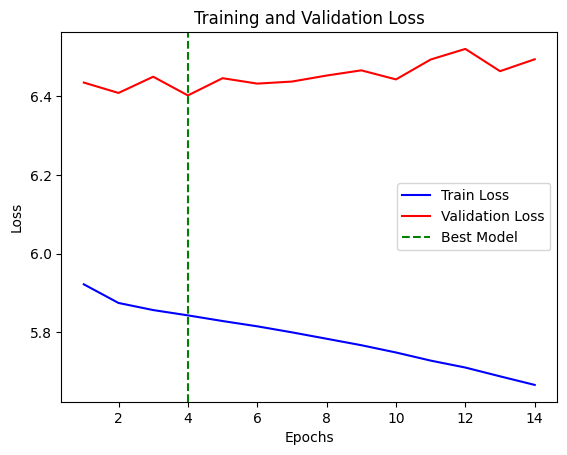

In [29]:
import matplotlib.pyplot as plt

# Sample lists of train and validation losses
# train_losses = [0.5, 0.4, 0.3, 0.2, 0.1]
# val_losses = [0.6, 0.5, 0.4, 0.3, 0.2]

# Plotting
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, 'b', label='Train Loss')
plt.plot(epochs, valid_losses, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

best_epoch = valid_losses.index(min(valid_losses)) + 1

# Add a vertical line at the epoch with the lowest validation loss
plt.axvline(x=best_epoch, color='g', linestyle='--', label='Best Model')

plt.legend()
plt.show()